<a href="https://colab.research.google.com/github/ideablast/NLPer_chatbot/blob/toram/Seq2Seq_Chatbot_%EC%9D%98%EB%A5%98_Transformer%2Bpretrained_Embedding(Kkma)_%EC%B9%B4%ED%85%8C%EA%B3%A0%EB%A6%AC_%EB%B6%84%EB%A5%98%EC%99%84%EB%A3%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install konlpy

     |████████████████████████████████| 19.4MB 1.2MB/s 
     |████████████████████████████████| 92kB 8.1MB/s 
     |████████████████████████████████| 460kB 53.7MB/s 
  Found existing installation: tweepy 3.6.0
    Uninstalling tweepy-3.6.0:
      Successfully uninstalled tweepy-3.6.0
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


## Import

In [3]:
from keras import models
from keras import layers
from keras import optimizers, losses, metrics
from keras import preprocessing

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
import gensim
from gensim.models import KeyedVectors

from konlpy.tag import Okt, Hannanum, Kkma, Komoran

## Hyperparameter

In [4]:
# 태그 단어
PAD = "<PADDING>"   # 패딩
STA = "<START>"     # 시작
END = "<END>"       # 끝
OOV = "<OOV>"       # 없는 단어(Out of Vocabulary)

# 태그 인덱스
PAD_INDEX = 0
STA_INDEX = 1
END_INDEX = 2
OOV_INDEX = 3

# 데이터 타입
ENCODER_INPUT  = 0
DECODER_INPUT  = 1
DECODER_TARGET = 2

# Hyper-parameters
NUM_LAYERS = 2
D_MODEL = 200 ##word embedding dim
NUM_HEADS = 4 ## D_Model % NUM_HEADS == 0이 되야하므로... D_MODEL / NUM_HEADS = d_k : 한 헤드에서 Q,K,V의 shape (D_MODEL, d_k)
UNITS = 512
DROPOUT = 0.1
EPOCHS = 50
# for data pipelining
BATCH_SIZE = 64
BUFFER_SIZE = 1000

VOCAB_SIZE = 0 # 후에 len(words) 로 바뀜.

# 한 문장에서 단어 시퀀스의 최대 개수
MAX_SEQ = 30

# 정규 표현식 필터
RE_FILTER = re.compile("[\"':;~()]")

## Data Load & Preprocessing

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [161]:
wear_data = pd.read_csv("/content/drive/My Drive/wear.csv")
print(wear_data.shape)
customer = wear_data[wear_data.SPEAKER == "고객"].SENTENCE
store = wear_data[wear_data.SPEAKER == "점원"].SENTENCE
print(customer.shape, store.shape) # 질문의 개수와 답의 개수가 일치하지 않는다.

(15826, 20)
(8381,) (7445,)


In [162]:
main = wear_data['MAIN']
main.shape
category = wear_data['CATEGORY']
category.shape
all_stc = wear_data['SENTENCE']
all_stc

0                신발은 여기 있는 게 다예요?
1                 네 성인이나 아동 다 있어요
2                   발 사이즈 몇 신으세요?
3                           230이요
4             편하게 신을 수 있는 거 찾으세요?
                   ...           
15821                이 쿠폰에 적립해주세요
15822     사은품 받으려면 쿠폰 몇 개 모아야 해요?
15823    쿠폰 몇 개 모으면 사은품 받을 수 있어요?
15824    쿠폰 몇 장 모아야 사은품 받을 수 있나요?
15825     사은품 받으려면 쿠폰 몇 장 있어야 돼요?
Name: SENTENCE, Length: 15826, dtype: object

In [8]:
print(main.shape, all_stc.shape)

(15826,) (15826,)


In [9]:
# 고객과 점원의 질,답 쌍으로 만들기
prev = "고객"
store_arr = []
customer_arr = []
store_stc = ""
customer_stc = ""
main_arr = []
category_arr = []

for i in range(wear_data.shape[0]):
    if (prev == wear_data.iloc[i].SPEAKER):
        if prev == "점원":
             store_stc += (" "+wear_data.iloc[i].SENTENCE)
        else : 
             customer_stc += (" "+wear_data.iloc[i].SENTENCE)
            
    elif prev == "점원":
        store_arr.append(store_stc)
        customer_stc = wear_data.iloc[i].SENTENCE
        prev = "고객"
        main_arr.append(main[i])
    else :
        customer_arr.append(customer_stc)
        store_stc = wear_data.iloc[i].SENTENCE
        prev = "점원"
        category_arr.append(category[i])

print(len(store_arr))
print(len(customer_arr))
print(store_arr[-1])
print(customer_arr[-1]) # 자료 상에서 이후에는 계속 고객의 물음만 계속된다. 코드 레벨에서 이 부분은 빼게 구현했다. (stc는 만들어지지만 arr에 append 안하게 된다.)
print(len(category_arr))

7301
7301
요즘 파스텔 톤이 유행이에요
요즘 유행하는 색깔이 뭐예요?
7301


In [10]:
for i in range(25):
    print(customer_arr[i])
    print(store_arr[i])
    print(main_arr[i]) # MAIN 행으로 하기에는 너무 쌍이 안맞다,,,
    print(category_arr[i])
    print() 

 신발은 여기 있는 게 다예요?
네 성인이나 아동 다 있어요 발 사이즈 몇 신으세요?
종류별신발제품문의요청
신발

230이요
편하게 신을 수 있는 거 찾으세요?
착화감
신발

네 봄이니까 편하게 신을 수 있는 거
이런 건 어떠세요? 이런 거도 신발 무척 편하거든요
굽높이문의
신발

굽 좀 높은 거 없나요?
봄 상품은 아직 어른 제품이 많이 안나왔습니다
재입고문의
신발

언제 들어와요?
이번주 지나면 들어올 거예요
소재문의
신발

이거는 가죽이에요?
가죽 아니고 쎄무예요
제품가격문의
신발

가죽은 얼마예요?
2만 9천 원입니다
사이즈재고문의
신발

털 달린 거 저거는 사이즈 있어요?
230이 없어요  이거 한 번 신어보세요
사이즈문의
신발

좀 크네 또 안 들어와요?
네 이건 다 끝났어요
종류별가방제품문의요청
신발

가방 매는 거 보고 있어요
여기 있어요
제품가격문의
가방

가격이 얼마예요?
이 종류는 2만 원이고 이 종류는 3만 8천 원이에요
소재를제시한제품문의
가방

가죽으로 된 거는 없어요?
가죽은 없고 레자만 있어요
제품가격문의
가방

레자는 얼마예요?
5만 5천 원요
가방소재문의
가방

이거는 천이죠?
네 맞아요
제품가격문의
가방

이건 얼마예요?
그것도 5만 5천 원요
제품구성문의
가방

이거 끈은 따로 없어요?
안에 있어요
공휴일영업문의
가방

내일은 문 열어요?
휴무입니다
공휴일영업문의
가방

며칠까지 휴무예요?
설까지 쉬고 다음날 열 거 같아요
제품가격문의
가방

여기 마스크는 얼마예요?
5천 원요
제품소재문의
가방

이거 나무예요? 다 돌인가요?
나무도 있고 도자기도 있어요
세트제품개별구매문의
액세서리

이런 건 세트로 팔아요?
네 세트로만 팔아요
제품소재문의
액세서리

이건 뭐예요?
마블이라고 종이를 말아가지고 하는 거예요
제품가격문의
액세서리

제일 큰 거는 얼마인데요?
세트에 7만 원이요
종류별액세서리제품문의요청
액세서리

스카프 좀 보려구요
네 천천히 보세요
계절상품문의
액세서리

실크스카프도 봄에 하나요?
실크 봄 가을에 하죠
제품문의

In [11]:
# 형태소분석 함수
def pos_tag(sentences):
    
    # KoNLPy 형태소분석기 설정
    tagger = Kkma()
    
    # 문장 품사 변수 초기화
    sentences_pos = []
    
    # 모든 문장 반복
    for sentence in sentences:
        # [\"':;~()] 특수기호 제거
        sentence = re.sub(RE_FILTER, "", sentence)
        
        # 배열인 형태소분석의 출력을 띄어쓰기로 구분하여 붙임
        sentence = " ".join(tagger.morphs(sentence))
        sentences_pos.append(sentence)
        
    return sentences_pos

In [12]:
# 형태소분석 수행
question = pos_tag(customer_arr)
answer = pos_tag(store_arr)

# 형태소분석으로 변환된 챗봇 데이터 출력
for i in range(5):
    print('Q : ' + question[i])
    print('A : ' + answer[i])
    print()


Q : 신발 은 여기 있 는 것 이 다예 이 요 ?
A : 네 성인 이나 아동 다 있 어요 발 사이즈 몇 신 으세요 ?

Q : 230 이요
A : 편하 게 신 을 수 있 는 거 찾 으세요 ?

Q : 네 봄 이 니까 편하 게 신 을 수 있 는 거
A : 이런 건 어 어 떠세 이 요 ? 이런 거도 신발 무척 편하 거든요

Q : 굽 좀 높 은 거 없 나요 ?
A : 봄 상품 은 아직 어른 제품 이 많이 안 나오 았 습니다

Q : 언제 들어오 아요 ?
A : 이번 주 지나 면 들어오 ㄹ 거 이 에요



In [13]:
# 질문과 대답 문장들을 하나로 합침
sentences = []
sentences.extend(question)
sentences.extend(answer)

words = []

# 단어들의 배열 생성
for sentence in sentences:
    for word in sentence.split():
        words.append(word)

# 길이가 0인 단어는 삭제
words = [word for word in words if len(word) > 0]

# 중복된 단어 삭제
words = list(set(words))

#제일 앞에 태그 단어 삽입. 기존 단어들은 뒤로 밀림.
words[:0] = [PAD, STA, END, OOV]

In [14]:
VOCAB_SIZE = len(words)
print("손님과 점원의 말에서 사용된 총 단어의 수 :",len(words))

손님과 점원의 말에서 사용된 총 단어의 수 : 3508


In [15]:
# 단어와 인덱스의 딕셔너리 생성
word_to_index = {word: index for index, word in enumerate(words)}
index_to_word = {index: word for index, word in enumerate(words)}

In [16]:
# 문장을 인덱스로 변환(정수인코딩)
def convert_text_to_index(sentences, vocabulary, type): 
    
    sentences_index = []
    
    # 모든 문장에 대해서 반복
    for sentence in sentences:
        sentence_index = []
        
        # 디코더 입력일 경우 맨 앞에 START 태그 추가
        if type == DECODER_INPUT:
            sentence_index.extend([vocabulary[STA]])
        
        # 문장의 단어들을 띄어쓰기로 분리
        for word in sentence.split():
            if vocabulary.get(word) is not None:
                # 사전에 있는 단어면 해당 인덱스를 추가
                sentence_index.extend([vocabulary[word]])
            else:
                # 사전에 없는 단어면 OOV 인덱스를 추가
                sentence_index.extend([vocabulary[OOV]])

        # 최대 길이 검사
        if type == DECODER_TARGET:
            # 디코더 목표일 경우 맨 뒤에 END 태그 추가
            if len(sentence_index) >= MAX_SEQ:
                sentence_index = sentence_index[:MAX_SEQ-1] + [vocabulary[END]]
            else:
                sentence_index += [vocabulary[END]]
        else:
            if len(sentence_index) > MAX_SEQ:
                sentence_index = sentence_index[:MAX_SEQ]
            
        # 최대 길이에 없는 공간은 패딩 인덱스로 채움
        sentence_index += (MAX_SEQ - len(sentence_index)) * [vocabulary[PAD]]
        
        # 문장의 인덱스 배열을 추가
        sentences_index.append(sentence_index)

    return np.asarray(sentences_index)

In [17]:
# 인코더 입력 인덱스 변환
x_encoder = convert_text_to_index(question, word_to_index, ENCODER_INPUT)

# 첫 번째 인코더 입력 출력 (신발 은 여기 있는 게 다예 요)
print(question[0])
x_encoder[0]


신발 은 여기 있 는 것 이 다예 이 요 ?


array([ 886, 3413, 1091, 3193, 3355, 1319, 3313, 2372, 3313, 2265,  542,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0])

In [18]:
# 디코더 입력 인덱스 변환
x_decoder = convert_text_to_index(answer, word_to_index, DECODER_INPUT)

# 첫 번째 디코더 입력 출력 (<START> 신발 은 여기 있는 게 다예 요)
print(answer[0])
x_decoder[0]


네 성인 이나 아동 다 있 어요 발 사이즈 몇 신 으세요 ?


array([   1, 2558,  676, 2685, 1868, 2506, 3193, 1825, 2449, 2394, 1073,
       1225, 1168,  542,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0])

In [19]:
# 디코더 목표 인덱스 변환
y_decoder = convert_text_to_index(answer, word_to_index, DECODER_TARGET)

# 첫 번째 디코더 입력 출력 (신발 은 여기 있는 게 다예 요 <END>)
print(answer[0])
y_decoder[0]


네 성인 이나 아동 다 있 어요 발 사이즈 몇 신 으세요 ?


array([2558,  676, 2685, 1868, 2506, 3193, 1825, 2449, 2394, 1073, 1225,
       1168,  542,    2,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0])

## Load Pretrained Embedding model
 - from https://github.com/Kyubyong/wordvectors 's korean(w2v)
 - 200 dim
 - this model trained 330M corpus(tagged by Kkma)


In [20]:
emb_model = gensim.models.Word2Vec.load('/content/drive/My Drive/ko.bin')
emb_model.save("base_word2vec_200d.model") #기본 full 모델 백업, 더 Train할때 #type: gensim.models.word2vec.Word2Vec

word_vectors = emb_model.wv
word_vectors.save("base_word2vec_200d.wordvectors") #기본 KeyedVecotros 모델 백업, 더 train안시킬때, 로드속도 및 메모리 손실 적음
# Load back with memory-mapping = read-only, shared across processes.
wv = KeyedVectors.load("base_word2vec_200d.wordvectors", mmap='r') #type: gensim.models.keyedvectors.Word2VecKeyedVectors

In [21]:
#일단 추가 학습 없이 해보자.
emb_layer = wv.get_keras_embedding(train_embeddings=False)

## Transformer

In [22]:
# decoder inputs use the previous target as input
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': x_encoder,
        'dec_inputs': x_decoder
    },
    {
        'outputs': y_decoder
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [23]:
dataset

<PrefetchDataset shapes: ({inputs: (None, 30), dec_inputs: (None, 30)}, {outputs: (None, 30)}), types: ({inputs: tf.int64, dec_inputs: tf.int64}, {outputs: tf.int64})>

$$\Large{Attention(Q, K, V) = softmax_k(\frac{QK^T}{\sqrt{d_k}}) V} $$

In [24]:
## scaled dot product Attention
def scaled_dot_product_attention(query, key, value, mask):
  matmul_qk = tf.matmul(query, key, transpose_b=True) # QK^T

  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth) #  QK^T / sqrt(d_k)

  if mask is not None:
    logits += (mask * -1e9) # zero padding token softmax 결과가 0이 나오도록
  
  attention_weights = tf.nn.softmax(logits, axis = -1) # softmax(QK^T / sqrt(d_k))

  output = tf.matmul(attention_weights, value) # softmax(QK^T / sqrt(d_k)) * V

  return output

In [25]:
## multi-head attention
## each head need (scaled_dot_product_attention)
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0 # 128,8

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)
  
  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(inputs, shape=(batch_size,-1,self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3]) ##????
  
  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    #linear
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    #split heads
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    #scaled dot-product attention
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    #concatenation of heads
    concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))

    #final linear
    outputs = self.dense(concat_attention)

    return outputs

In [26]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

In [27]:
#print(create_padding_mask(tf.constant([[1, 2, 0, 3, 0], [0, 0, 0, 4, 5]])))

In [28]:
# it handle mask future tokens in a sequence used decoder. and mask pad tokens
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

In [29]:
#print(create_look_ahead_mask(tf.constant([[1, 2, 0, 4, 5]])))

Positional encoding

since we don't use any rnn, cnn, positional encoding give model position information of words in sentence.

positional encoding vector is added to embedding vector

$$\Large{PE_{(pos, 2i)} = sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = cos(pos / 10000^{2i / d_{model}})} $$

In [30]:
class PositionalEncoding(tf.keras.layers.Layer):
  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)
  
  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles #pos/10000^(2i/d_model)

  def positional_encoding(self, position, d_model):
    angle_rads = self.get_angles(
        position = tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i = tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model = d_model)
    sines = tf.math.sin(angle_rads[:, 0::2])
    cosines = tf.math.cos(angle_rads[:, 1::2])

    pos_encoding = tf.concat([sines, cosines], axis=-1)
    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)
  
  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

### Encoder Layer
1. Multi-head attention (with padding mask)
2. 2 dense layers followed by dropout

also has residual connection followd by a layer normalization.

In [31]:
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query':inputs,
          'key':inputs,
          'value':inputs,
          'mask':padding_mask
      })
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention)

  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

### Encoder
1. Input Embedding
2. Positional Encoding
3. `num_layers` encoder layers

Embedding + positional encoding : input

going encoder layers.

output going decoder

In [32]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  embeddings = emb_layer(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)#??왜 vocab_size가 들어가지?

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = encoder_layer(
        units = units,
        d_model = d_model,
        num_heads = num_heads,
        dropout = dropout,
        name = "encoder_layer_{}".format(i),
    )([outputs, padding_mask])
  
  return tf.keras.Model(
      inputs = [inputs, padding_mask], outputs = outputs, name=name)

### Decoder Layer
1. Masked multi-head attention (with look ahead mask and padding mask)
2. Multi-head attention (with padding mask). `value` and `key` is from encoder output. `query` is from Multi-head attention layer output
3. 2 dense layers followed by dropout

also has residual connection followd by a layer normalization.

In [33]:
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(shape=(1,None,None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1,1,None), name="padding_mask")

  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query' : inputs,
          'key' : inputs,
          'value' : inputs,
          'mask' : look_ahead_mask
      })
  attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention1 + inputs)

  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query' : attention1,
          'key' : enc_outputs,
          'value' : enc_outputs,
          'mask' : padding_mask
      })
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention2 + attention1)

  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs = [inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs = outputs,
      name = name)

### Decoder
1. output Embedding
2. Positional Encoding
3. `num_layers` decoder layers

Embedding + positional encoding : input (target)

going decoder layers.

output going final linear layer

In [34]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="decoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(shape=(1,None,None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1,1,None), name='padding_mask')

  embeddings = emb_layer(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units = units,
        d_model = d_model,
        num_heads = num_heads,
        dropout = dropout,
        name = "decoder_layer_{}".format(i),
    )(inputs = [outputs, enc_outputs, look_ahead_mask, padding_mask])
  
  return tf.keras.Model(
      inputs = [inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs = outputs,
      name = name)

### Transformer
1. encoder
2. decoder
3. final linear layer

In [35]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1,1,None),
      name="enc_padding_mask")(inputs)
  
  #mask future tokens for decoder inputs at 1st attention block
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask, output_shape=(1,None,None),
      name="look_ahead_mask")(dec_inputs)
  
  #mask encoder outputs for the 2nd attention block
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1,1,None),
      name="dec_padding_mask")(inputs)
  
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

## 모델 생성

In [36]:
tf.keras.backend.clear_session()

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

In [37]:
model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 200)    6771224     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

### Loss function
since target sequences are padded, deal this.

In [38]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_SEQ))

  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)
  
  mask = tf.cast(tf.not_equal(y_true,0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

### Custom learning rate
use Adam optimizer with custom learning rate
$$\Large{lrate = d_{model}^{-0.5} * min(step{\_}num^{-0.5}, step{\_}num * warmup{\_}steps^{-1.5})}$$

In [39]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

### Compile Model

In [40]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  # ensure labels have shape (batch_size, MAX_LENGTH - 1)
  y_true = tf.reshape(y_true, shape=(-1, MAX_SEQ))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

## Train

In [41]:
model.fit(dataset, epochs=EPOCHS)

Epoch 1/50
115/115 [==============================] - 3s 28ms/step - loss: 2.4699 - accuracy: 0.0182
Epoch 2/50
115/115 [==============================] - 3s 23ms/step - loss: 2.1507 - accuracy: 0.0333
Epoch 3/50
115/115 [==============================] - 3s 22ms/step - loss: 1.7957 - accuracy: 0.0409
Epoch 4/50
115/115 [==============================] - 3s 22ms/step - loss: 1.5844 - accuracy: 0.0569
Epoch 5/50
115/115 [==============================] - 3s 22ms/step - loss: 1.4621 - accuracy: 0.0734
Epoch 6/50
115/115 [==============================] - 3s 22ms/step - loss: 1.3556 - accuracy: 0.0871
Epoch 7/50
115/115 [==============================] - 3s 22ms/step - loss: 1.2670 - accuracy: 0.0978
Epoch 8/50
115/115 [==============================] - 3s 22ms/step - loss: 1.1986 - accuracy: 0.1053
Epoch 9/50
115/115 [==============================] - 3s 23ms/step - loss: 1.1423 - accuracy: 0.1107
Epoch 10/50
115/115 [==============================] - 3s 23ms/step - loss: 1.0963 - accura

## 카테고리 분류

In [175]:
category_info = pd.DataFrame({"stc":all_stc, "cate":main})
category_info.dropna(inplace = True)
category_info.reset_index(drop=True, inplace = True)

tagger = Okt()

for i in range(category_info.shape[0]):
    category_info['stc'][i] = tagger.morphs(category_info['stc'][i])


In [176]:
category_info
category_list = pd.factorize(category_info['cate'])[1]
category_info['cate'] = pd.factorize(category_info['cate'])[0]
category_list

Index(['종류별신발제품문의요청', '착화감', '굽높이문의', '재입고문의', '소재문의', '제품가격문의', '사이즈재고문의',
       '사이즈문의', '종류별가방제품문의요청', '소재를제시한제품문의',
       ...
       '맞춤문의/요청', '스타일선택/요청', '고객변심에의한환불/반품/교환요청', '카카오페이/삼성페이결제',
       '교환/환불가능기간문의', '환불/반품/교환요청/문의', 'A/S신청문의', '특수제질세무/가죽세탁문의',
       '종류별신발제품문의/요청', '선물포장문의/요청'],
      dtype='object', length=405)

In [177]:
from sklearn.model_selection import train_test_split

# train, test로 데이터 분리하기
X_train, X_test, y_train, y_test = train_test_split(
    category_info['stc'], category_info['cate'], test_size = 0.2, shuffle = True, random_state = 11)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print(len(y_train[0]))
print(len(y_test[0]))

405
405


In [178]:
from tensorflow.keras.preprocessing.text import Tokenizer

# 헤드라인 정수 인코딩
tokenizer = Tokenizer(5000) # Tokenizer 객체 생성 -> 아래 셀을 통해 3번 이상 나온 단어의 수가 약 25000개인 것을 알 수 있고, 상위 25000개만 쓰겠다는 뜻으로 인자를 넘긴다.
tokenizer.fit_on_texts(X_train) # news_train에 있는 단어에 정수 인코딩

X_train = tokenizer.texts_to_sequences(X_train) # 실제로 정수 할당
X_test = tokenizer.texts_to_sequences(X_test) # 실제로 정수 할당

# 이제 headline들이 정수의 배열로 이뤄지게 된다.

In [179]:
print(len(tokenizer.word_index))

wc = 0
for word, word_count in tokenizer.word_counts.items():
    if word_count <= 2:
        wc += 1

print(wc)

5903
3642


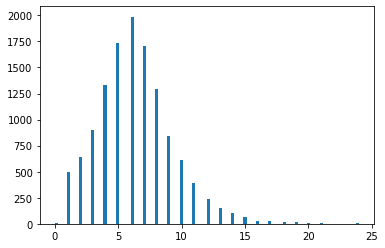

In [180]:
import matplotlib.pyplot as plt

len_stc = []
for data in X_train:
    len_stc.append(len(data))

y, x, _ = plt.hist(len_stc, bins=100)
plt.show()

In [181]:
max_len = 15
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [182]:
model = Sequential()
model.add(Embedding(25000, 128))
model.add(LSTM(128))
model.add(Dense(405, activation='softmax'))

In [183]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=64, epochs=30)

Epoch 1/30
197/197 [==============================] - 5s 23ms/step - loss: 4.9347 - acc: 0.1138 - val_loss: 4.7263 - val_acc: 0.1205
Epoch 2/30
197/197 [==============================] - 4s 21ms/step - loss: 4.5407 - acc: 0.1391 - val_loss: 4.3627 - val_acc: 0.1596
Epoch 3/30
197/197 [==============================] - 4s 21ms/step - loss: 4.1397 - acc: 0.1824 - val_loss: 4.0082 - val_acc: 0.2118
Epoch 4/30
197/197 [==============================] - 4s 21ms/step - loss: 3.6919 - acc: 0.2491 - val_loss: 3.6790 - val_acc: 0.2655
Epoch 5/30
197/197 [==============================] - 4s 21ms/step - loss: 3.2913 - acc: 0.3144 - val_loss: 3.4852 - val_acc: 0.2871
Epoch 6/30
197/197 [==============================] - 4s 21ms/step - loss: 2.9438 - acc: 0.3650 - val_loss: 3.3051 - val_acc: 0.3192
Epoch 7/30
197/197 [==============================] - 4s 21ms/step - loss: 2.6366 - acc: 0.4171 - val_loss: 3.1880 - val_acc: 0.3440
Epoch 8/30
197/197 [==============================] - 4s 21ms/step - 

In [184]:
model.evaluate(X_test, y_test)

99/99 [==============================] - 0s 3ms/step - loss: 3.7172 - acc: 0.3905


[3.71718168258667, 0.3904610574245453]

In [194]:
def find_category(stc):
    stc = tagger.morphs(stc)
    encode_stc = tokenizer.texts_to_sequences([stc])
    pad_stc = pad_sequences(encode_stc, maxlen=15)

    score = model.predict(pad_stc)
    return (category_list[score.argmax()], score[0, score.argmax()])

위의 두 개 문장은 데이터셋에 없는 문장임에도 잘 분류해낸다. 약 20% 이상의 정확도만 보이면 써도 될 거 같다. 세 번째 문장은 데이터셋에 있는 문장인데 그래서 그런지 굉장히 높은 정확도를 보인다.

In [195]:
sentence = "이 코트에 어울리는 치마 있나요?"
print(find_category(sentence))
sentence = "같은 디자인으로 혹시 더 저렴한 상품 있나요?"
print(find_category(sentence))
sentence = "겨울이니까 좀 길게 입으셔야죠"
print(find_category(sentence))

('종류별의류제품문의요청', 0.903083)
('가격대별문의', 0.8279469)
('착용후어울리는지문의', 0.9877182)


## Predict

In [ ]:
# 인덱스를 문장으로 변환
def convert_index_to_text(indexs, vocabulary): 
    
    sentence = ''
    
    # 모든 문장에 대해서 반복
    for index in indexs:
        if index == END_INDEX:
            # 종료 인덱스면 중지
            break;
        if vocabulary.get(index) is not None:
            # 사전에 있는 인덱스면 해당 단어를 추가
            sentence += vocabulary[index]
        else:
            # 사전에 없는 인덱스면 OOV 단어를 추가
            sentence.extend([vocabulary[OOV_INDEX]])
            
        # 빈칸 추가
        sentence += ' '

    return sentence

In [ ]:
# 예측을 위한 입력 생성
def make_predict_input(sentence):

    sentences = []
    sentences.append(sentence)
    sentences = pos_tag(sentences)
    input_seq = convert_text_to_index(sentences, word_to_index, ENCODER_INPUT)
    
    return input_seq

In [ ]:
def evaluate(input_seq):

  input_seq = input_seq.squeeze()
  sentence = tf.expand_dims(input_seq, axis=0)
  output = tf.expand_dims([1], 0)

  for i in range(MAX_SEQ):
    predictions = model(inputs=[sentence, output], training=False)

    # select the last word from the seq_len dimension
    predictions = predictions[:, -1:, :]
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # return the result if the predicted_id is equal to the end token
    if tf.equal(predicted_id, 2):
      break

    # concatenated the predicted_id to the output which is given to the decoder
    # as its input.
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0)

In [ ]:
convert_index_to_text(evaluate(make_predict_input('와이프 선물로 뭐가 좋을까요?')).numpy()[1:],index_to_word)

'반지 는 느낌 의 청바지 로 되 어 있 는데 어 있 어요 '

In [ ]:
convert_index_to_text(evaluate(make_predict_input('내일 뭐해요?')).numpy()[1:],index_to_word)

'내일 은 지금 이 라 , 오래되 과 밤색 었 어요 '

In [ ]:
convert_index_to_text(evaluate(make_predict_input('이거 사이즈 큰거 있어요?')).numpy()[1:],index_to_word)

'그 사이즈 99 이상 짜 리 신발 찾 으세요 ? '

In [ ]:
convert_index_to_text(evaluate(make_predict_input('이거 사이즈 230 있어요?')).numpy()[1:],index_to_word)

'네 '

In [ ]:
convert_index_to_text(evaluate(make_predict_input('할인 되요?')).numpy()[1:],index_to_word)

'네 '

In [ ]:
# for train data predict
for seq_index in range(0,100):

  print("고객 : ",question[seq_index])
  print("정답점원 :",answer[seq_index])
  print("AI점원 :",convert_index_to_text(evaluate(make_predict_input(question[seq_index])).numpy()[1:],index_to_word))
  print("\n")

고객 :  신발 은 여기 있 는 것 이 다예 이 요 ?
정답점원 : 네 성인 이나 아동 다 있 어요 발 사이즈 몇 신 으세요 ?
AI점원 : 네 , 안 에 있 는 것 이 다예 요 


고객 :  230 이요
정답점원 : 편하 게 신 을 수 있 는 거 찾 으세요 ?
AI점원 : 편하 게 신 을 수 있 는 신발 은 어 어 떠세 이 요 ? 


고객 :  네 봄 이 니까 편하 게 신 을 수 있 는 거
정답점원 : 이런 건 어 어 떠세 이 요 ? 이런 거도 신발 무척 편하 거든요
AI점원 : 네 , 그럼 이 디자인 은 쇼핑백 에 있 는데 신 어 어 떠세 이 요 ? 


고객 :  굽 좀 높 은 거 없 나요 ?
정답점원 : 봄 상품 은 아직 어른 제품 이 많이 안 나오 았 습니다
AI점원 : 이런 제품 은 잘 나 가요 


고객 :  언제 들어오 아요 ?
정답점원 : 이번 주 지나 면 들어오 ㄹ 거 이 에요
AI점원 : 다음 주 정도 는 안 되 면 바로 


고객 :  이거 는 가죽 이 에요 ?
정답점원 : 가죽 아니 고 쎄무예 요
AI점원 : 네 , 그거 는 다 이 에요 


고객 :  가죽 은 얼마 이 에요 ?
정답점원 : 2 만 9 천 원 이 ㅂ니다
AI점원 : 2 만 5 천 원 이 에요 


고객 :  털 달리 ㄴ 거 저거 는 사이즈 있 어요 ?
정답점원 : 230 이 없 어요 이거 한 번 신 어 보 세요
AI점원 : 이 옷 도 크 어요 


고객 :  좀 크 네 또 안 들어오 아요 ?
정답점원 : 네 이건 다 끝나 었 어요
AI점원 : 그러 면 27 사이즈 는 어떻 게 되 세요 ? 


고객 :  가방 매 는 거 보 고 있 어요
정답점원 : 여기 있 어요
AI점원 : 이 가방 은 어 떠세 이 요 ? 


고객 :  가격 이 얼마 이 에요 ?
정답점원 : 이 종류 는 2 만 원 이 고 이 종류 는 3 만 8 천 원 이 에요
AI점원 : 가격 은 태그 에 적히 어 있 어요 


고객 :  가죽 으로 되 ㄴ 거 는 없 어요 ?
정답점원 : 가죽 은 없 고 레 자만 

## Test data prediction
 - 문장중 14900행부터의 문장 100개에 대한 예측.

In [ ]:
test_question_arr = []
test_question = ""

for i in range(14900,wear_data.shape[0]):
        test_question = wear_data.iloc[i].SENTENCE
        test_question_arr.append(test_question)

# test_question_arr = pos_tag(test_question_arr)

In [ ]:
# for train data predict
for seq_index in range(0,100):

  print("고객 : ",test_question_arr[seq_index])
  print("AI점원 :",convert_index_to_text(evaluate(make_predict_input(test_question_arr[seq_index])).numpy()[1:],index_to_word))
  print("\n")

고객 :  구제는 뭐예요?
AI점원 : 그 깃털 소재 는 밍크 이 에요 


고객 :  구제 옷도 있네요?
AI점원 : 네 


고객 :  구제품은 다 세탁해서 나온 거예요?
AI점원 : 네 , 세탁기 로 나오 는 제품 이 에요 


고객 :  이건 다 세탁이 된 거죠?
AI점원 : 네 


고객 :  구제품은 세탁해서 파시는 건가요?
AI점원 : 네 그렇 습니다 


고객 :  구제품은 다 세탁해서 나오는 거겠죠?
AI점원 : 네 , 다 다르 ㄴ 거 있 어요 


고객 :  카드로 결제하면 부가세 별도에요?
AI점원 : 그 옆 에 가격 같 은 경우 에 오시 면 되 ㅂ니다 


고객 :  카드는 부가세 별도로 붙나요?
AI점원 : 그 제품 은 카드 로 구입 하 시 어도 부가세 가 똑같 아요 


고객 :  카드 결제하면 부가세 추가되나요?
AI점원 : 네 


고객 :  카드로 하면 부가세 붙어요?
AI점원 : 흰색 은 카드 로 하 시 면 이 더 붙 어요 


고객 :  포인트 적립되는 거 뭐 있어요?
AI점원 : 내일 모레 까지 이 에요 


고객 :  이거 적립되죠?
AI점원 : 네 


고객 :  몸에 딱 붙는 옷인가요?
AI점원 : 그 옷 은 프리 에 요 


고객 :  몸에 딱 붙는 티셔츠 있어요?
AI점원 : 네 


고객 :  원피스 중에 몸에 딱 붙는 건 없어요?
AI점원 : 다 나가 었 어요 


고객 :  할인 코너는 어디에요?
AI점원 : 여기 하고 바깥쪽 에 있 는 할인 아니 에요 


고객 :  할인 코너는 어디에 있어요?
AI점원 : 여기 는 30 프로 에 있 어요 


고객 :  할인 코너는 따로 없어요?
AI점원 : 네 


고객 :  할인 코너는 어느 쪽에 있나요?
AI점원 : 네 통신사 카드 로 부터 할인 되 어 있 어요 


고객 :  영업은 매일 하시나요?
AI점원 : 네 , 오늘 은 여덟 은 여덟 은 여덟 은 없 어요 


고객 :  내일도 영업해요?
AI점원 : 네 


고객 :  매일 영업하시는 건가요?
AI점원 : 네